<h1><center>Naive Bayes & Gaussian Generative Model</center></h1>
<hr style="border:2px solid black"> </hr>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
confusion_matrices_nb = []
confusion_matrices_gm = []

## Read Data

In [2]:
def read_data(class_name:str):
    train = np.array([np.float64(plt.imread('Data/train/'+class_name+'/'+str(i)+'.jpg')).reshape(-1) for i in range (0,5000)],dtype=np.float64)/255
    test = np.float64(np.array([np.float64(plt.imread('Data/test/'+class_name+'/'+str(i)+'.jpg')).reshape(-1) for i in range (0,1000)],dtype=np.float64)/255)
    return train,test

# Creating Confusion Matrix for our results
def get_cm(test):
    c_air=0
    c_car=0
    c_frog=0
    counter=0
    cm=[]
    for i in test:
        c1=i[0]
        c2=i[1]
        c3=i[2]
        if(c1>=c2 and c1>=c3):
            c_air=c_air+1
        elif(c2>=c1 and c2>=c3):
            c_car=c_car+1
        elif(c3>=c1 and c3>=c2):
            c_frog=c_frog+1
        counter=counter+1
        if(counter==1000):
            cm.append([c_air,c_car,c_frog])
            c_air=0
            c_car=0
            c_frog=0
            counter=0
    return np.array(cm)

In [3]:
airplane_train,airplane_test = read_data('airplane')
automobile_train,automobile_test = read_data('automobile')
frog_train,frog_test = read_data('frog')
X_test=np.concatenate((airplane_test,automobile_test,frog_test))

<hr style="border:2px solid black"> </hr>

## Construct Naive Bayes classifier for each of the 3 classes.

In [4]:
import warnings
warnings.filterwarnings('ignore')

# We had infinitites when multiplying the probabilities of pixels so we took the log of each pixel prob
# and instead of the product of prob we got the sum of logs which is equivilant
# a*b*c = log(a)+log(b)+log(c)

def Gaussian(x,mean,variance):
    return np.float64((np.exp(((np.float64((x-mean)**2))*(-1))/(np.float64(2*variance)) )/np.float64(np.sqrt(2*np.pi*variance))))
    
def naive_classifier(class1,test):
    # class1 mean
    mean = class1.mean(axis=0).reshape(1,-1)
    variance = class1.var(axis=0).reshape(1,-1)
    prob = [ Gaussian(i,mean,variance) for i in test ]
    result = [np.prod(np.float64(i),dtype=np.float64) for i in prob]
    return np.array(result)

def naive_bayes(N):
    X_testResized=image_resize(N,X_test)
    airplane_results = naive_classifier(image_resize(N,airplane_train),X_testResized).reshape(-1,1)
    automobile_results = naive_classifier(image_resize(N,automobile_train),X_testResized).reshape(-1,1)
    frog_results = naive_classifier(image_resize(N,frog_train),X_testResized).reshape(-1,1)
    cm=get_cm(np.concatenate((airplane_results,automobile_results,frog_results),axis=1))
    return cm

def image_resize(n,images):
    resized = [cv2.resize(i.reshape((32,32,3)), (n,n), interpolation=cv2.INTER_AREA).reshape(-1) for i in images]
    return np.array(resized)

<hr style="border:2px solid black"> </hr>

## Construct Gaussian Generative Model classifier for each of the 3 classes.

In [8]:
def covariance(images,mean):
    result=np.dot(np.transpose(images-mean),images-mean)
    return result

def total_covariance(a,b,c):
    x=covariance(a,a.mean(axis=0).reshape(1,-1))
    y=covariance(b,b.mean(axis=0).reshape(1,-1))
    z=covariance(c,c.mean(axis=0).reshape(1,-1))
    return x+y+z
    
def gaussian_classifier(class1,cov_inverse,test):
    mean =class1.mean(axis=0).reshape(1,-1)
    result=np.array([],dtype=np.float64)
    for i in test:
        temp = i-mean
        k = -0.5*np.exp(np.dot(np.dot(temp,cov_inverse),np.transpose(temp))[0][0])
        result = np.append(result,k)
    return result

def gaussian_generative_model(N):
    cov_matrix=total_covariance(image_resize(N,airplane_train),image_resize(N,automobile_train),image_resize(N,frog_train))
    cov_inverse=np.linalg.pinv(cov_matrix)
    X_testRes=image_resize(N,X_test)
    
    airplane_resultsG = gaussian_classifier(image_resize(N,airplane_train),cov_inverse,X_testRes).reshape(-1,1)
    automobile_resultsG = gaussian_classifier(image_resize(N,automobile_train),cov_inverse,X_testRes).reshape(-1,1)
    frog_resultsG = gaussian_classifier(image_resize(N,frog_train),cov_inverse,X_testRes).reshape(-1,1)

    return get_cm(np.concatenate((airplane_resultsG,automobile_resultsG,frog_resultsG),axis=1))

<hr style="border:2px solid black"> </hr>

## Repeat steps for for image sizes 16,8,4.

In [9]:
cmN_32= naive_bayes(32)
cmN_16= naive_bayes(16)
cmN_8= naive_bayes(8)
cmN_4= naive_bayes(4)

In [10]:
cmG_32=gaussian_generative_model(32)
cmG_16=gaussian_generative_model(16)
cmG_8=gaussian_generative_model(8)
cmG_4=gaussian_generative_model(4)

In [11]:
confusion_matrices_nb = np.array([cmN_32,cmN_16,cmN_8,cmN_4])
confusion_matrices_gm = np.array([cmG_32,cmG_16,cmG_8,cmG_4])
confusion_matrices= np.append(confusion_matrices_nb, confusion_matrices_gm,axis=0)

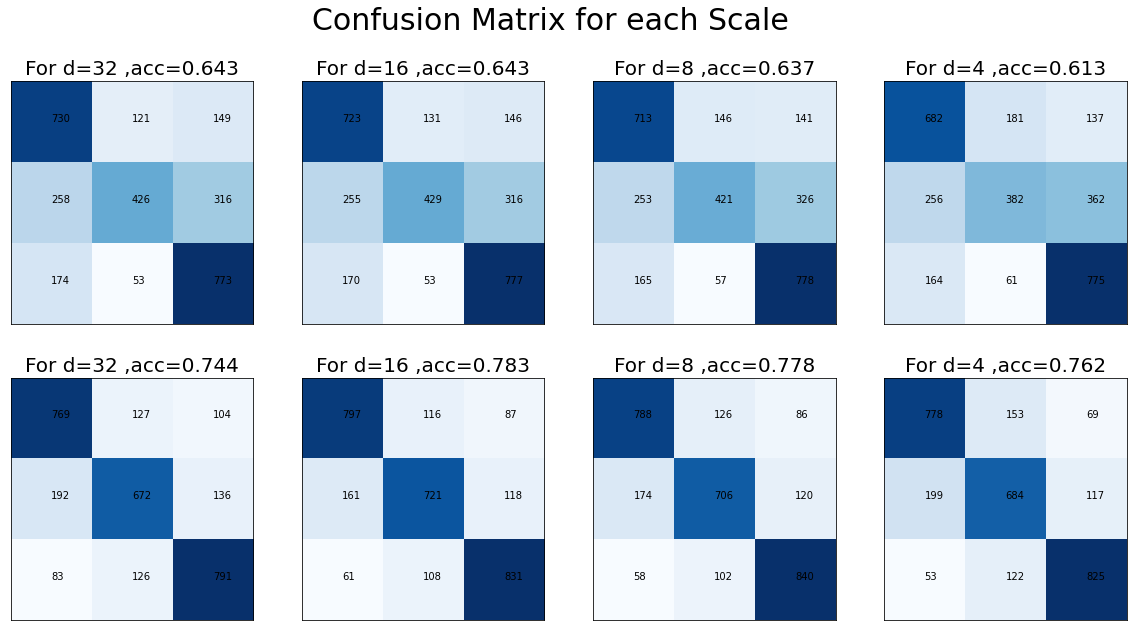

In [12]:
dims = [32,16,8,4,32,16,8,4]
fig, axs = plt.subplots(2, 4,figsize=(20,10))
fig.suptitle("Confusion Matrix for each Scale",fontsize=30)
for pi in range(0,axs.shape[0]):
    for pj in range(0,axs.shape[1]):
        index = np.round(pi*4+pj)
        cm = confusion_matrices[index]
        axs[pi,pj].matshow(cm,cmap="Blues")
        axs[pi,pj].set_title("For d="+str(dims[index])+" ,acc="+str(np.round(np.diag(cm).sum()/3000,3)),fontsize=20)
        for i in range(0,cm.shape[0]):
            for j in range(0,cm.shape[1]):
                axs[pi,pj].set_xticks([])
                axs[pi,pj].set_yticks([])
                axs[pi,pj].annotate(cm[i,j],(j,i))

Text(0.5, 1.0, 'NB VS GM')

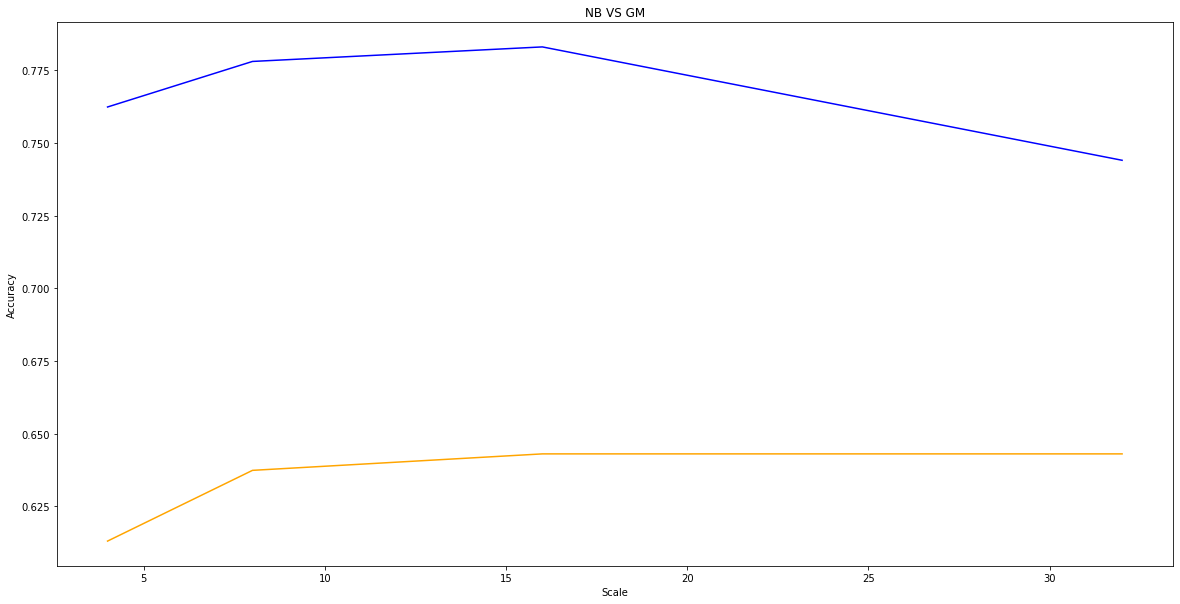

In [13]:
plt.figure(figsize=(20,10))
plt.plot(dims[:4],[np.diag(cm).sum()/3000 for cm in confusion_matrices_nb],color='orange')
plt.plot(dims[:4],[np.diag(cm).sum()/3000 for cm in confusion_matrices_gm],color='blue')
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.title('NB VS GM')

<hr style="border:2px solid black"> </hr>

## Comment on the results ##

### 
The Gaussian generative model is better than Naive Bayes since Naive assumes that all features are independent, but Gaussian doesn't. And in our case the pixels aren't independent, if a pixel has a certain color there is an extremely high probability that a neighboring pixel will have the same color. As for the Dimensionality, smaller dimensions can be better or the same since the data is less parse for the classifier, hence easier to group similar features closer together. Sometimes increasing the numbers of dimension might help classify the data better, but that's not always the case. In this case reducing the dimensionality made it easier and better for the classifier and this is called the curse of dimensionality in classification.
###